In [1]:
# manipulating and plotting arrays
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

# file handling and units
import tarfile
from tqdm import tqdm
import astropy
from astropy.io import fits
import astropy.constants as const
import astropy.units as u
from astropy.utils.data import download_file
from lightkurve.search import search_lightcurve

# machine learning and data packages

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.convolutional import Convolution1D, MaxPooling1D
from sklearn import metrics
import scipy



#setting random seeds
seed = 42
np.random.seed(seed)
import os
os.environ['PYTHONHASHSEED']=str(seed)
import random
random.seed(seed)
import tensorflow as tf
tf.random.set_seed(seed)

# read from cloud datasets as opposed to downloading from on-premise servers
from astroquery.mast import Observations
Observations.enable_cloud_dataset()


%matplotlib inline

INFO: Using the S3 STScI public dataset [astroquery.mast.cloud]


In [2]:
conda run pip install git+https://github.com/afeinstein20/stella

  Cloning https://github.com/afeinstein20/stella to /tmp/pip-req-build-onulh8ln
  Resolved https://github.com/afeinstein20/stella to commit f9ffd78d1c7279012e870f3657812595f18eee74
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'

  Running command git clone --filter=blob:none --quiet https://github.com/afeinstein20/stella /tmp/pip-req-build-onulh8ln


Note: you may need to restart the kernel to use updated packages.


In [3]:
import stella

# Exercise 1

First, we download the relevant data and confirm that we've plotted the correct lightcurve.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

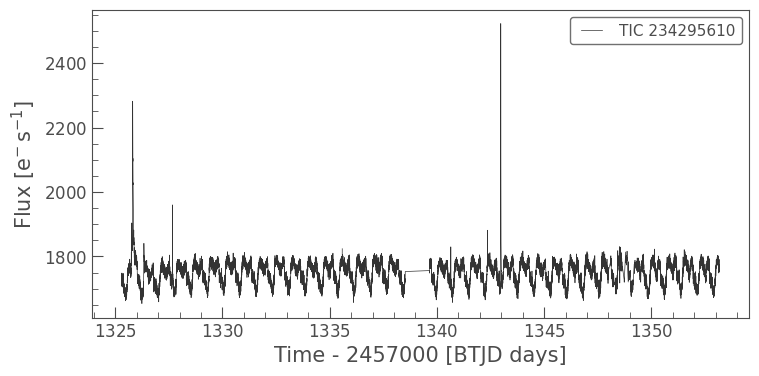

In [4]:
# ticids = ['278779899', '139754153', '273418879', '52121469', '188580272', '394015919', '402104884']
ticids = ['234295610']


# for all the selected targets, pull the available lightcurves using the lightkurve package
sectors = [1, 2] # only consider the first few sectors
lcs = []
for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
lc.plot()

Now, we'd like to inspect the quality flags for those high-flux time stamps. First, we select those regions. Note that we slice the lightcurve using `flux.values`, because otherwise we wouldn't be able to compare the flux array to the unitless `1900` value.

Because there's a large time separation between these values (that would be joined by a straight line), let's scatter plot the points.

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

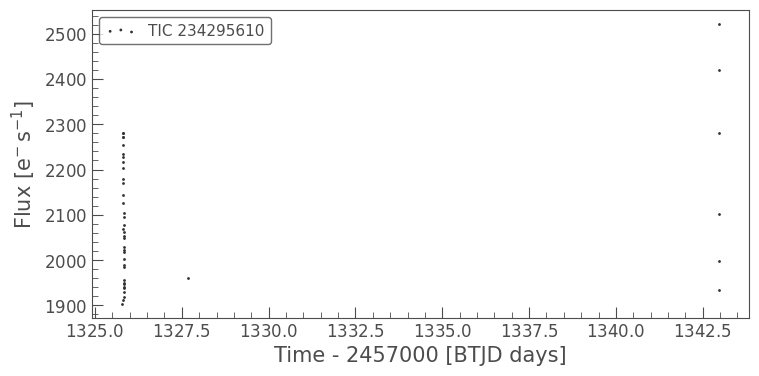

In [5]:
lc_check = lc[lc.flux.value>1900]
lc_check.scatter()

We'll use a code chunk from the [Quality Flags](../../02-quality-flags) notebook below.

In [6]:
quality = lc_check['quality']

bad_bits = np.array([1,2,3,4,5,6,8,10,12,13,15])
value = 0
for v in bad_bits:
    value = value + 2**(v-1)
    
bad_data = np.bitwise_and(quality, value) >= 1 

np.any(bad_data)

False

It seems that none of these high-flux timestamps were flagged by the TESS team as being bad-quality. This lends more credence to the idea that there is a real astrophysical source of the high flux — perhaps flares.

# Exercise 2

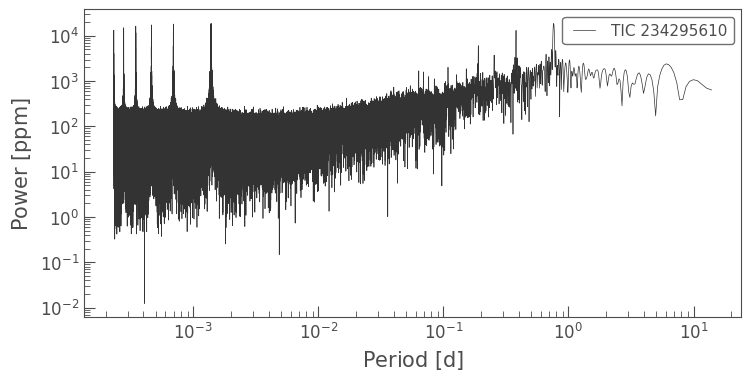

In [7]:
lc_interval = (lc.time.max() - lc.time.min()).value

max_period = lc_interval/2

min_period = 1 / 24 / 60 / 60 * 20

pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)

pg.plot(scale='log');

We'd like to investigate whether those peaks are harmonics

In [8]:
from scipy.signal import find_peaks

In [9]:
# peaks = find_peaks(pg.power, distance=2000)[0]
peaks = find_peaks(pg.power, height=12500, distance=800)[0]

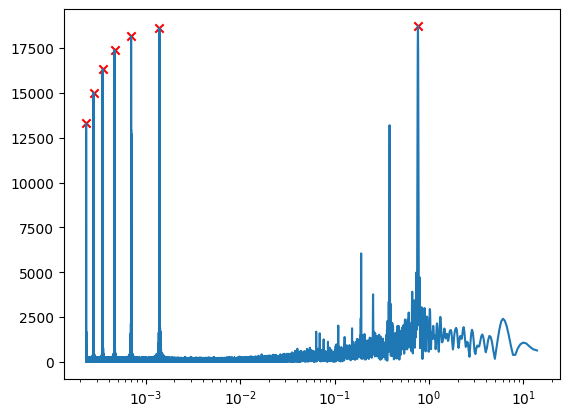

In [10]:
plt.plot(pg.period, pg.power)

plt.scatter(pg.period[peaks], pg.power[peaks], color='red', marker='x')
plt.xscale('log')

In [11]:
pg.period[peaks]

<Quantity [7.61765205e-01, 1.38636373e-03, 6.93813215e-04, 4.62682613e-04,
           3.47064660e-04, 2.77677030e-04, 2.31552268e-04] d>

In [12]:
first_harmonic = pg.period[peaks][1]

In [13]:
per_ratios = []
for per in pg.period[peaks][2:]:
    per_ratios += [first_harmonic/per]

per_ratios = np.array(per_ratios)
        

In [14]:
per_ratios

array([1.99818006, 2.99636013, 3.99454019, 4.99272026, 5.98726045])

Text(0, 0.5, 'Period ratio')

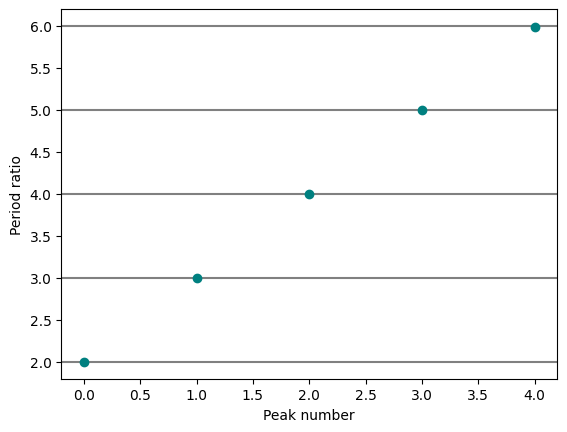

In [15]:
plt.axhline(2, color='gray')
plt.axhline(3, color='gray')
plt.axhline(4, color='gray')
plt.axhline(5, color='gray')
plt.axhline(6, color='gray')
plt.scatter(np.arange(len(per_ratios)), per_ratios, zorder=100, color='teal')

plt.xlabel('Peak number')
plt.ylabel('Period ratio')


The period ratios are close to integer values. Looks like harmonics here!

# Exercise 3

If we change this to just the 1-sigma outliers, the periodicity we're looking for is removed entirely. This is, in short, not good. The implication is that when cleaning our datasets, we should take care to not clean them so much that the signal of interest is removed.

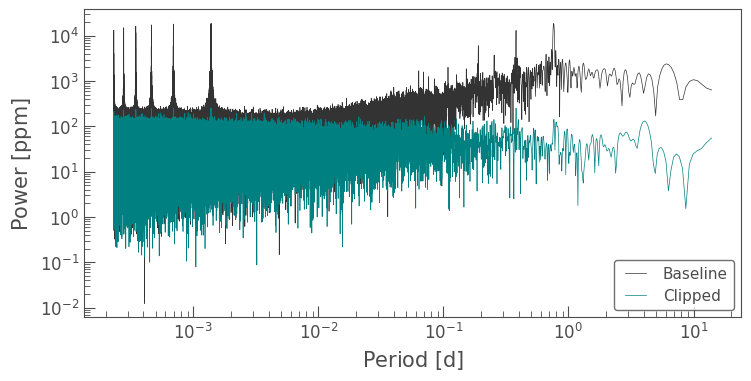

In [16]:
lc_clipped = lc.remove_outliers(sigma=1)

pg_clipped = lc_clipped.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)

ax = pg.plot(scale='log', label='Baseline')
# pg_clipped.plot(ax=ax, scale='log', zorder=1);
pg_clipped.plot(ax=ax, scale='log', color='teal', label='Clipped');




We can see that in the clippeed lightcurve, the periodogram peaks are still present, but they're only barely visible — and their amplitude is nearly consistent with noise. This feature makes sense when we take a look at the lightcurve that's been clipped. We've removed way too much of the lightcurve!

<AxesSubplot:xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

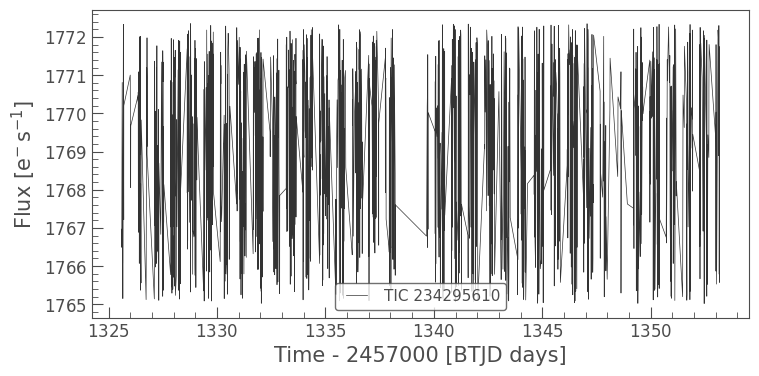

In [17]:
lc_clipped.plot()

# Exercise 4

In [18]:
data_dir = './hellouniverse_stella_500/'
filename = 'Guenther_2020_flare_catalog.txt'
ds = stella.FlareDataSet(fn_dir=data_dir,
                         catalog=data_dir+filename) # using the same catalog as above

Reading in training set files.


100%|██████████| 62/62 [00:00<00:00, 438.00it/s]

502 positive classes (flare)
1342 negative classes (no flare)
37.0% class imbalance



In [19]:
# remove lightcurves with NaNs from training, test and validation data
def remove_nans(input_data):
    '''Determine indices of files without NaNs'''

    idx = []
    for k in range(np.shape(input_data)[0]):
        if len(input_data[k, :, :][np.isnan(input_data[k, :, :])]) == 0:
            idx.append(k)
    return idx


# find indices in train, test and validation sets without NaNs
idx_train = remove_nans(ds.train_data)
idx_test = remove_nans(ds.test_data)
idx_val = remove_nans(ds.val_data)

ds.train_data = ds.train_data[idx_train]
ds.train_labels = ds.train_labels[idx_train]

ds.test_data = ds.test_data[idx_test]
ds.test_labels = ds.test_labels[idx_test]

ds.val_data = ds.val_data[idx_val]
ds.val_labels = ds.val_labels[idx_val]


In [20]:
# first, we load the mode.
cnn_file = 'initial_flare_model_small_dataset.h5' #AS: ask about where the files are from previous notebooks!
model = keras.models.load_model(cnn_file)

In [21]:
# set up the ConvNN object.
cnn_stella = stella.ConvNN(output_dir=data_dir, ds=ds)

In [22]:
cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 2ms/step


100%|██████████| 1/1 [00:03<00:00,  3.22s/it]


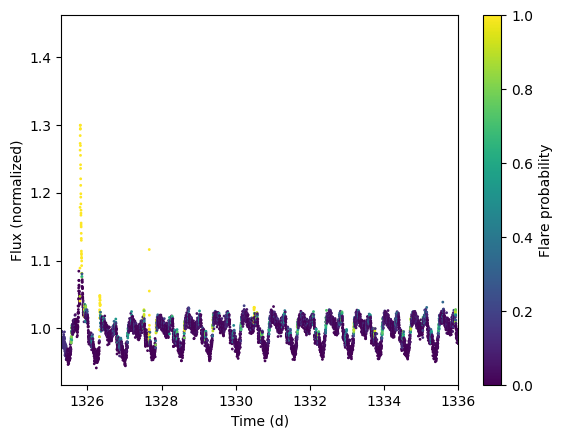

In [23]:
# cnn_stella.predict_flux[0]
fig, ax= plt.subplots()
im  = ax.scatter(cnn_stella.predict_time[0], cnn_stella.predict_flux[0], c=cnn_stella.predictions[0], s=1. )
plt.xlabel('Time (d)')
plt.ylabel('Flux (normalized)')
plt.colorbar(im, label='Flare probability')
plt.xlim(lc.time.min().value, 1336)
plt.show()


Now, we'd like to count the number of distinct flares. Let's count a transition into and out of hgih flare probability (greater than a rating of 0.5 by the classifier) as a flare.

In [24]:
ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])

In [25]:
ff

In [26]:
ff.identify_flare_peaks(threshold=0.5)
ff.flare_table

Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  2.19it/s]


Target_ID,tpeak,amp,ed_s,rise,fall,prob
float64,float64,float64,float64,float64,float64,float64
234295610.0,1336.5337294934927,1.0164458841762698,15.733979526711776,0.0001,0.01,0.7433666586875916
234295610.0,1336.6670634792652,1.030084465920081,77.18607677976796,0.01,0.01,0.503517746925354
234295610.0,1340.3767937687605,1.0188266236793928,19.615063032310957,0.0001,0.01,0.846248209476471
234295610.0,1341.9031816217816,1.0166045607867409,17.27435594647144,0.0001,0.01,0.5975300669670105
234295610.0,1344.9628970090544,1.0205275288684985,22.32319766900919,0.0001,0.01,0.715408205986023


These tell us a little more here! right now we're just going to count the flare rate in number of flares per day.

In [27]:
def calc_flare_rate(name):
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])
    
    ff.identify_flare_peaks(threshold=0.5)
    flare_rate = len(ff.flare_table) / (lc.time.value.max() - lc.time.value.min())    
    return flare_rate

Let's recalculate those rotation and flare rates.

In [28]:

G = const.G
M = 1 * u.M_sun
R = 1 * u.R_sun
vc = ((2/3) * G * M / R)**.5

P = 2 * np.pi * R  / vc

min_period = P.to(u.day).value/100

In [29]:
def calc_rotation_rate(name):
    """
    Calculates the roation period of a star, assuming that rotation is the primary driver of the star's periodicity. 
    
    Inputs
    ------
        :name: name of star (str)
        
    Outputs
    -------
        :period_at_max_power: the dominant period in the light curve. [float]
    """
    
    
    # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    pg = lc.normalize(unit='ppm').to_periodogram(maximum_period=max_period, minimum_period=min_period)
    
    return pg.period_at_max_power


filename = 'Guenther_2020_flare_catalog.txt'

catalog = astropy.io.ascii.read(data_dir + filename)  
stars = catalog['TIC'].data




rot_rates = []

# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    
    rot_rate = calc_rotation_rate(star_name)
    
    # store result of rotation rate calculation
    rot_rates += [rot_rate]

 27%|██▋       | 12/44 [01:07<01:12,  2.27s/it]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 61%|██████▏   | 27/44 [01:19<00:14,  1.18it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
 73%|███████▎  | 32/44 [01:23<00:09,  1.24it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/units/quantity.py:673: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
100%|██████████| 44/44 [01:32<00:00,  2.10s/it]


In [30]:
flare_rates = []
for star in stars[::200]:
    flare_rate = calc_flare_rate(str(star))
    
    flare_rates += [flare_rate]

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

569/569 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

537/537 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

568/568 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

541/541 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 1s 2ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

554/554 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00, 21.22it/s]


In [31]:
rot_rates = [rot_rate.value for rot_rate in rot_rates]

/tmp/ipykernel_252/212443149.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal')


Text(0, 0.5, 'Period at max power (d)')

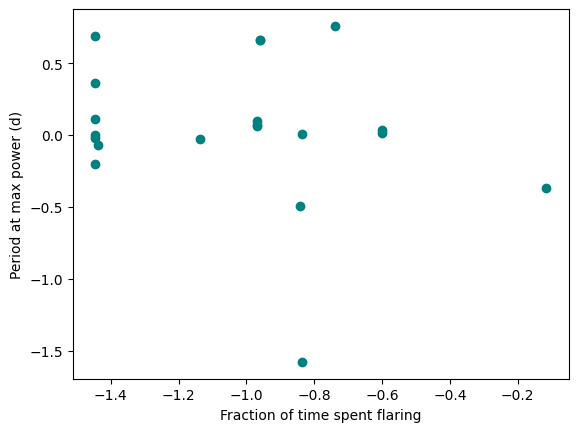

In [32]:
plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal')
            
plt.xlabel('Fraction of time spent flaring')
plt.ylabel('Period at max power (d)')

In [33]:
rot_rates, flare_rates = np.array(rot_rates), np.array(flare_rates)

In [34]:
rot_rates_cleaned = rot_rates[flare_rates>0.0]
flare_rates_cleaned = flare_rates[flare_rates>0.0]

In [35]:
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned))

In [36]:
x = np.linspace(np.min(np.log10(flare_rates_cleaned)), np.max(np.log10(flare_rates_cleaned)), 100)
y = slope * x + intercept

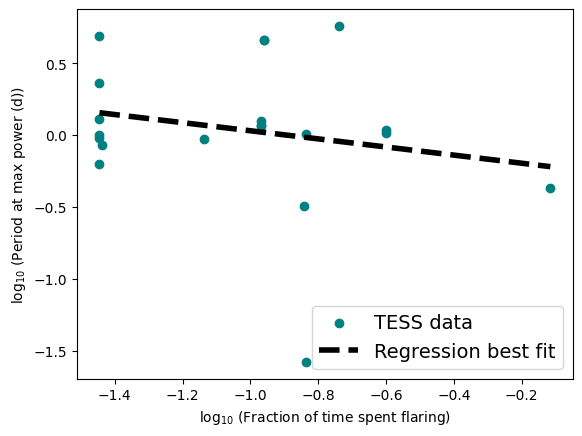

In [37]:
plt.scatter(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned), color='teal', label='TESS data')
plt.plot(x,y, color='black', linestyle='--', lw=4, label='Regression best fit')
            
plt.xlabel(r'$\log_{10}$' + ' (Fraction of time spent flaring)')
plt.ylabel(r'$\log_{10}$' + ' (Period at max power (d))')
plt.legend(fontsize=14);

This is not nearly as tight a relationship. The number of flares must be measuring a fundamentally different quantity than the fraction of time spent flaring. Or, if the two metrics do measure the same quantity, this most recent approach must do so in a much more messy way.

# Exercise 5

We can most easily solve this by writing a new function to find rotation periods.

In [38]:
def calc_rotation_rate_stella(name):
     # for all the selected targets, pull the available lightcurves using the lightkurve package
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    lc = lc.normalize()
    lc = lc.remove_nans()
    mProt = stella.MeasureProt([lc.targetid], [lc.time.value], [lc.flux.value], [lc.flux_err.value])
    mProt.run_LS()

    return mProt.LS_results['period_days'].value[0]

In [39]:
rot_rates_constrained = []

# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    
    rot_rate = calc_rotation_rate_stella(star_name)
    
    # store result of rotation rate calculation
    rot_rates_constrained += [rot_rate]

100%|██████████| 44/44 [00:13<00:00,  3.28it/s]


In [40]:
len(rot_rates_constrained) == len(rot_rates)

True

Looks like we didn't lose any rotation rates by being more precise. How do the plots change?

/tmp/ipykernel_252/1714143192.py:9: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal', label='TESS data')


-0.2824260738079636 -0.2526836958618884


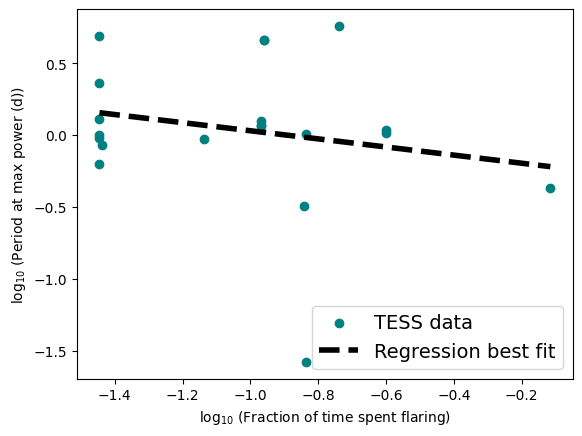

In [41]:
rot_rates_cleaned = rot_rates[flare_rates>0.0]
flare_rates_cleaned = flare_rates[flare_rates>0.0]

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_cleaned), np.log10(rot_rates_cleaned))

x = np.linspace(np.min(np.log10(flare_rates_cleaned)), np.max(np.log10(flare_rates_cleaned)), 100)
y = slope * x + intercept

plt.scatter(np.log10(flare_rates), np.log10(rot_rates), color='teal', label='TESS data')
plt.plot(x,y, color='black', linestyle='--', lw=4, label='Regression best fit')
            
plt.xlabel(r'$\log_{10}$' + ' (Fraction of time spent flaring)')
plt.ylabel(r'$\log_{10}$' + ' (Period at max power (d))')
plt.legend(fontsize=14);

print(slope, intercept)



Looks like we get a slightly steeper relationship this way.

# Exercise 6

Now, let's be more stringent with our flares. We'll use equivalent duration (area underneath the flare) as a proxy for flare duration.

In [42]:
second_to_day_factor = (1 * u.day / (1 * u.second)).si.value

In [43]:
def calc_flare_rate(name):
    """
    todo: add docstring.
    """
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    cnn_stella.predict(cnn_file, times=lc.time.value, fluxes=lc.flux, errs=lc.flux_err)
    
    ff = stella.FitFlares(id=[lc.targetid],
                      time=[lc.time.value],
                      flux=[lc.flux.value],
                      flux_err=[lc.flux_err.value],
                      predictions=[cnn_stella.predictions[0]])
    
    ff.identify_flare_peaks(threshold=0.5)
    
    flare_duration_seconds = np.sum(ff.flare_table['ed_s'].value)
    flare_duration_seconds_days = flare_duration_seconds * second_to_day_factor
    flare_rate = flare_duration_seconds_days / (lc.time.value.max() - lc.time.value.min())    
    return flare_rate

In [44]:
flare_rates

array([0.        , 0.10946732, 0.        , 0.03586705, 0.        ,
       0.        , 0.14595592, 0.        , 0.        , 0.        ,
       0.10760323, 0.10760116, 0.25107012, 0.03586712, 0.        ,
       0.03586792, 0.07297653, 0.        , 0.14346661, 0.        ,
       0.76625318, 0.        , 0.14595388, 0.        , 0.        ,
       0.03586692, 0.        , 0.        , 0.25106915, 0.03586751,
       0.        , 0.10760205, 0.        , 0.        , 0.        ,
       0.03648907, 0.        , 0.10946634, 0.        , 0.        ,
       0.        , 0.        , 0.18244348, 0.03586796])

In [45]:
flare_rates_durations = []
for star in stars[::200]:
    flare_rate = calc_flare_rate(str(star))
    
    flare_rates_durations += [flare_rate]

  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

569/569 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

537/537 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

568/568 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

520/520 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

541/541 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:938: RuntimeWarning: All-NaN slice encountered
  kwargs["initial"] = initial_func(self.unmasked)
/opt/conda/envs/tess/lib/python3.8/site-packages/astropy/utils/masked/core.py:827: RuntimeWarning: invalid value encountered in true_divide
  result = getattr(ufunc, method)(*unmasked, **kwargs)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

570/570 [==============================] - 2s 3ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

572/572 [==============================] - 1s 2ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
  0%|          | 0/1 [00:00<?, ?it/s]

554/554 [==============================] - 1s 3ms/step


Finding & Fitting Flares:   0%|          | 0/1 [00:00<?, ?it/s]/opt/conda/envs/tess/lib/python3.8/site-packages/stella/mark_flares.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(results)
Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00, 14.60it/s]


In [46]:
flare_rates_durations

[0.0,
 108740.01343691128,
 0.0,
 29252.779498824162,
 0.0,
 0.0,
 1194959.7854249156,
 0.0,
 0.0,
 0.0,
 101055.42124183405,
 126701.76203768862,
 74294.33964908683,
 48134.097568698606,
 0.0,
 17264.24741817222,
 61213.83752228067,
 0.0,
 1666683.7267428858,
 0.0,
 7890923.28989539,
 0.0,
 261751.00965558251,
 0.0,
 0.0,
 101256.5687663477,
 0.0,
 0.0,
 169363.88477421636,
 10437.141586177333,
 0.0,
 127260.77254492122,
 0.0,
 0.0,
 0.0,
 15033.14688429129,
 0.0,
 95261.60611277254,
 0.0,
 0.0,
 0.0,
 0.0,
 243426.73034144117,
 7318.485193742318]

-0.3494300409805593 1.795846016798184


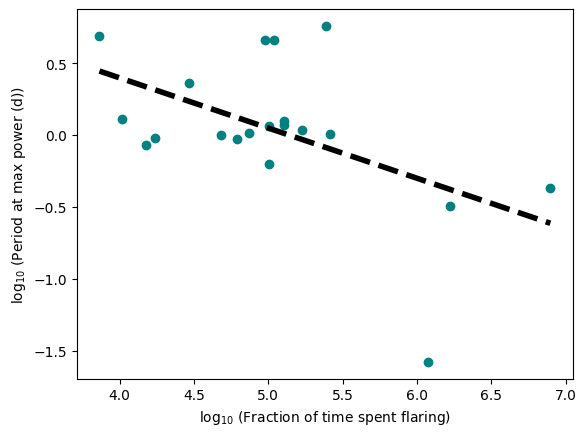

In [47]:
flare_rates_durations = np.array(flare_rates_durations)
rot_rates_cleaned = rot_rates[flare_rates_durations>0.0]
flare_rates_durations_cleaned = flare_rates_durations[flare_rates_durations>0.0]


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_durations_cleaned), np.log10(rot_rates_cleaned))

x = np.linspace(np.min(np.log10(flare_rates_durations_cleaned)), np.max(np.log10(flare_rates_durations_cleaned)), 100)
y = slope * x + intercept

plt.scatter(np.log10(flare_rates_durations_cleaned), np.log10(rot_rates_cleaned), color='teal', label='TESS data')
plt.plot(x,y, color='black', linestyle='--', lw=4, label='Regression best fit')
plt.xlabel(r'$\log_{10}$' + ' (Fraction of time spent flaring)')
plt.ylabel(r'$\log_{10}$' + ' (Period at max power (d))')

print(slope, intercept)

This looks pretty similar to our trend from the previous plot — maybe even a bit tighter. We'll test the significance of things in the next exercise.

# Exercise 7

Now, let's assess the statistical signficance of our fit. There are a number of ways to do this, but one of the more rigorous is hierarchical Bayesian model selection. Basically, we'll fit a linear model to our rotation data and see if it is preferred over a flat line (with no relationship between our quantities).

The most robust way to perform this experiment first involves getting uncertainties on our rotation rates. To do so, we'll use Gaussian processes via the [exoplanet package](https://gallery.exoplanet.codes/tutorials/stellar-variability/).


In [48]:
!pip install celerite2


  Using cached celerite2-0.2.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (921 kB)


In [557]:
lc2 = lc.remove_nans().remove_outliers()
lc2 = lc2[:5000]
_, mask = lc2.flatten().remove_outliers(sigma=3.0, return_mask=True)
lc2 = lc2[~mask]

x = np.ascontiguousarray(lc2.time.value, dtype=np.float64)
y = np.ascontiguousarray(lc2.flux, dtype=np.float64)
yerr = np.ascontiguousarray(lc2.flux_err, dtype=np.float64)
mu = np.mean(y)
y = (y / mu - 1) * 1e3
yerr = yerr * 1e3 / mu

In [563]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

with pm.Model() as model:
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=0.0, sigma=10.0)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(0.76), sigma=2.0)
    period = pm.Deterministic("period", tt.exp(log_period))
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=tt.exp(log_Q0),
        dQ=tt.exp(log_dQ),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + tt.exp(2 * log_jitter),
        mean=mean,
        quiet=True,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize(progress=True)

optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -17797.54833147572 -> -15571.358082651843


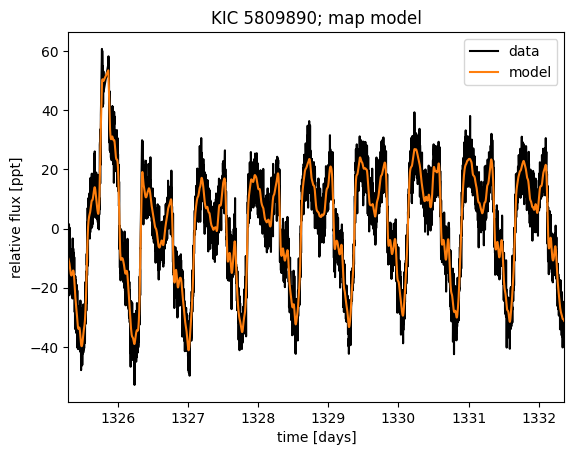

In [564]:
plt.plot(x, y, "k", label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("KIC 5809890; map model");

In [565]:
with model:
    trace = pmx.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        cores=4,
        chains=2,
        target_accept=0.9,
        return_inferencedata=True,
        random_seed=[10863087, 10863088],
        progressbar=True
    )

Multiprocess sampling (2 chains in 4 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]
INFO:pymc3:NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 201 seconds.
INFO:pymc3:Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 201 seconds.
There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 38 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [566]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "f",
        "log_dQ",
        "log_Q0",
        "log_period",
        "sigma_rot",
        "rho",
        "sigma",
        "log_jitter",
        "mean",
    ],
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
f,0.569,0.216,0.223,0.959,0.021,0.015,108.0,310.0,1.01
log_dQ,-2.392,1.224,-4.846,-0.356,0.034,0.025,1334.0,1235.0,1.00
log_Q0,0.491,1.928,0.000,0.222,0.595,0.433,59.0,11.0,1.03
log_period,-0.883,0.077,-1.027,-0.743,0.005,0.003,290.0,1237.0,1.01
sigma_rot,20.652,2.914,16.678,28.821,0.765,0.552,46.0,9.0,1.05
rho,0.927,0.321,0.321,1.431,0.045,0.032,43.0,11.0,1.03
sigma,3.229,4.297,0.845,8.489,1.404,1.025,40.0,12.0,1.04
log_jitter,-1.260,0.932,-3.038,0.086,0.033,0.024,956.0,842.0,1.00
mean,0.553,2.030,-3.245,4.349,0.082,0.058,671.0,1352.0,1.00


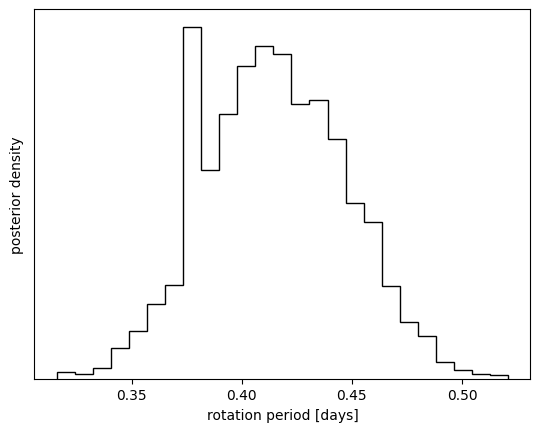

In [567]:
period_samples = np.asarray(trace.posterior["period"]).flatten()
plt.hist(period_samples, 25, histtype="step", color="k", density=True)
plt.yticks([])
plt.xlabel("rotation period [days]")
_ = plt.ylabel("posterior density")

With this process established for a single star, let's do the same for a bunch of stars. Note that this code can take up to a few hours to run.

In [62]:
def fit_rotation_gp(name, period_init):
    sectors = [1, 2] # only consider the first few sectors
    lcs = []
    # for name in ticids:
    lc = search_lightcurve(target='TIC'+name, mission='TESS', sector=sectors, author='SPOC')
    lc = lc.download_all()[0]
    
    lc2 = lc.remove_nans().remove_outliers()
    lc2 = lc2[:5000]
    _, mask = lc2.flatten().remove_outliers(sigma=3.0, return_mask=True)
    lc2 = lc2[~mask]

    x = np.ascontiguousarray(lc2.time.value, dtype=np.float64)
    y = np.ascontiguousarray(lc2.flux, dtype=np.float64)
    yerr = np.ascontiguousarray(lc2.flux_err, dtype=np.float64)
    mu = np.mean(y)
    y = (y / mu - 1) * 1e3
    yerr = yerr * 1e3 / mu
    
    with pm.Model() as model:
        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0.0, sigma=10.0)

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

        # A term to describe the non-periodic variability
        sigma = pm.InverseGamma(
            "sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        rho = pm.InverseGamma(
            "rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0)
        )

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma(
            "sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0)
        )
        log_period = pm.Normal("log_period", mu=np.log(period_init), sigma=2.0)
        period = pm.Deterministic("period", tt.exp(log_period))
        log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.1, upper=1.0)

        # Set up the Gaussian Process model
        kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
        kernel += terms.RotationTerm(
            sigma=sigma_rot,
            period=period,
            Q0=tt.exp(log_Q0),
            dQ=tt.exp(log_dQ),
            f=f,
        )
        gp = GaussianProcess(
            kernel,
            t=x,
            diag=yerr**2 + tt.exp(2 * log_jitter),
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=y)

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(y))

        # Optimize to find the maximum a posteriori parameters
        map_soln = pmx.optimize(progress=False)
        
    with model:
        trace = pmx.sample(
            tune=1000,
            draws=1000,
            start=map_soln,
            cores=4,
            chains=2,
            target_accept=0.9,
            return_inferencedata=True,
            random_seed=[10863087, 10863088],
            progressbar=False
        )
        
    period_samples = np.asarray(trace.posterior["period"]).flatten()
    np.save(f'period_samples{name}.npy', period_samples)
    return period_samples


    

In [74]:
rot_rates_gp = []

# iterate though stars
for i, star in tqdm(enumerate(stars[::200]), total=len(stars[::200])):
    # if i <= 2: # already calculated
    #     continue
    star_name = str(star) # the rotation rate function takes strings
    period_guess = rot_rates_constrained[i]
    
    rot_rate_gp_samples = fit_rotation_gp(star_name, period_guess)
    
    # store result of rotation rate calculation
    rot_rates_gp += [rot_rate_gp_samples]

  0%|          | 0/44 [00:00<?, ?it/s]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -11367.680540031417 -> -10838.90086879937
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 215 seconds.
  2%|▏         | 1/44 [03:55<2:48:50, 235.58s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -18398.428275291306 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 212 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
  5%|▍         | 2/44 [07:50<2:44:48, 235.44s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -10780.009981153857 -> -10199.694035366387
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 194 seconds.
  7%|▋         | 3/44 [11:27<2:34:52, 226.64s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -16362.494201186906 -> -15691.785364461639
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 163 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
  9%|▉         | 4/44 [14:32<2:20:06, 210.17s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -11496.498157177246 -> -10857.319328149646
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 182 seconds.
 11%|█▏        | 5/44 [17:57<2:15:28, 208.43s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -13321.824822092423 -> -12720.951290646624
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 198 seconds.
 14%|█▎        | 6/44 [21:38<2:14:40, 212.64s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -29653.95415454962 -> -28949.376594665915
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1165 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
 16%|█▌        | 7/44 [41:25<5:27:33, 531.17s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -13978.908014140832 -> -13344.606466638263
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 142 seconds.
 18%|█▊        | 8/44 [44:10<4:08:49, 414.70s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -11823.950085090839 -> -11202.359781800997
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 189 seconds.
 20%|██        | 9/44 [47:42<3:24:59, 351.42s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -4470.094438889526 -> -4051.8429511084014
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 229 seconds.
The acceptance probability does not match the target. It is 0.9621645770001219, but should be close to 0.9. Try to increase the number of tuning steps.
 23%|██▎       | 10/44 [51:56<3:02:03, 321.29s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -13952.569946753769 -> -13263.44439462204
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 228 seconds.
The number of effective samples is smaller than 25% for some parameters.
 25%|██▌       | 11/44 [56:07<2:44:54, 299.82s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -18537.35070343634 -> -17918.973604228253
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 278 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.
 27%|██▋       | 12/44 [1:01:06<2:39:48, 299.64s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -8202.302441011596 -> -7609.662067101156
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 166 seconds.
 30%|██▉       | 13/44 [1:04:13<2:17:04, 265.31s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -13971.005944647799 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 221 seconds.
The number of effective samples is smaller than 25% for some parameters.
 32%|███▏      | 14/44 [1:08:15<2:09:10, 258.36s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -7752.8314890646 -> -7073.53955723816
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 138 seconds.
 34%|███▍      | 15/44 [1:10:56<1:50:40, 228.99s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -15720.996684969496 -> -14975.438935281794
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 168 seconds.
 36%|███▋      | 16/44 [1:14:05<1:41:12, 216.87s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -17484.730265924558 -> -16853.050338265726
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 144 seconds.
 39%|███▊      | 17/44 [1:16:49<1:30:27, 201.01s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -11135.672724288695 -> -10344.641872954087
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 173 seconds.
 41%|████      | 18/44 [1:20:02<1:26:07, 198.77s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -33301.154415652076 -> -13980.007062491197
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 214 seconds.
The number of effective samples is smaller than 25% for some parameters.
 43%|████▎     | 19/44 [1:23:58<1:27:25, 209.84s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -14793.319629735885 -> -13723.104419264278
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 245 seconds.
The number of effective samples is smaller than 25% for some parameters.
 45%|████▌     | 20/44 [1:28:26<1:30:55, 227.32s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -15452.108260326759 -> -9625.829378965407
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 161 seconds.
 48%|████▊     | 21/44 [1:31:29<1:22:04, 214.11s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -12638.407302069034 -> -11939.939893924378
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 234 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 50%|█████     | 22/44 [1:35:45<1:23:02, 226.46s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -15825.666062130416 -> -14123.407907197181
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 179 seconds.
 52%|█████▏    | 23/44 [1:39:04<1:16:24, 218.31s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -13505.262155231307 -> -12674.670546862262
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 146 seconds.
 55%|█████▍    | 24/44 [1:41:51<1:07:36, 202.84s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -14152.590186620298 -> -13398.26461258055
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 170 seconds.
 57%|█████▋    | 25/44 [1:45:02<1:03:10, 199.50s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -15444.153148654255 -> -14504.467336352558
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 171 seconds.
 59%|█████▉    | 26/44 [1:48:15<59:16, 197.56s/it]  optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -10328.01160938214 -> -9780.58972173004
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 169 seconds.
 61%|██████▏   | 27/44 [1:51:27<55:25, 195.63s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -10084.441191690486 -> -9491.157449924931
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 248 seconds.
There were 29 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8157743187989067, but should be close to 0.9. Try to increase the number of tuning steps.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 64%|██████▎   | 28/44 [1:55:55<57:57, 217.35s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -20300.79532077235 -> -19594.688390744694
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 195 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7926075438336738, but should be close to 0.9. Try to increase the number of tuning steps.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7462618690287038, but should be close to 0.9. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.
 66%|██████▌   | 29/44 [1:59:31<54:14, 216.95s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -7851.377715730647 -> -7363.437249390066
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 186 seconds.
 68%|██████▊   | 30/44 [2:02:57<49:52, 213.74s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -14534.42453972514 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 168 seconds.
 70%|███████   | 31/44 [2:06:07<44:45, 206.61s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -11133.745138222359 -> -10726.813468526687
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 153 seconds.
 73%|███████▎  | 32/44 [2:09:00<39:18, 196.56s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -16018.283640054133 -> -15340.184101575569
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 117 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
 75%|███████▌  | 33/44 [2:11:18<32:50, 179.12s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -8313.12075460078 -> -7609.35397100296
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 173 seconds.
 77%|███████▋  | 34/44 [2:14:33<30:36, 183.67s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -9285.6023475647 -> -8699.050872354312
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 674 seconds.
 80%|███████▉  | 35/44 [2:26:09<50:36, 337.44s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -13658.221391508765 -> -12852.82013743503
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 234 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
 82%|████████▏ | 36/44 [2:30:24<41:41, 312.74s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -6774.930187470527 -> -6039.179643621371
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 151 seconds.
 84%|████████▍ | 37/44 [2:33:16<31:33, 270.47s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -13483.453035613375 -> -12667.6381436581
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 231 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
 86%|████████▋ | 38/44 [2:37:29<26:31, 265.28s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -5182.982763385706 -> -4532.833412931544
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 131 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
 89%|████████▊ | 39/44 [2:40:00<19:15, 231.10s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -4915.442315618915 -> -4222.085388279759
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 129 seconds.
The acceptance probability does not match the target. It is 0.9635025919082575, but should be close to 0.9. Try to increase the number of tuning steps.
 91%|█████████ | 40/44 [2:42:30<13:46, 206.69s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -12890.61577968222 -> -12318.918908940537
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 127 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
 93%|█████████▎| 41/44 [2:44:58<09:27, 189.15s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -13344.900778915508 -> -12614.530825600668
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 173 seconds.
 95%|█████████▌| 42/44 [2:48:13<06:21, 190.76s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -5669.293454630546 -> -4706.343816396637
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 159 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
 98%|█████████▊| 43/44 [2:51:14<03:07, 187.76s/it]optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -2258.3580750732044 -> -1569.0571136954245
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 154 seconds.
100%|██████████| 44/44 [2:54:09<00:00, 237.49s/it]


We can plot a few of these distributions to get a sense of scale here.

Text(0, 0.5, 'Count')

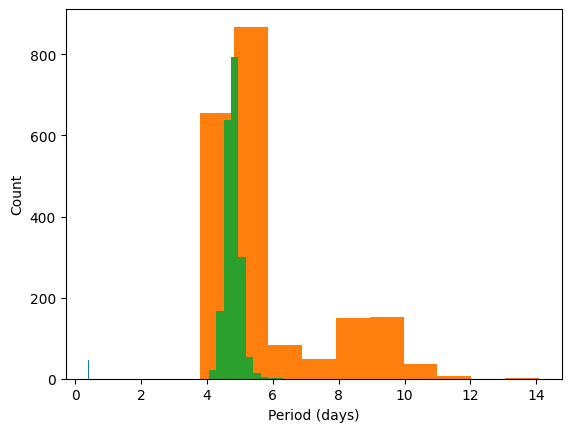

In [554]:
plt.hist(rot_rates_gp[0])
plt.hist(rot_rates_gp[1])
plt.hist(rot_rates_gp[-1])
plt.xlabel('Period (days)')
plt.ylabel('Count')

It looks like there's pretty significant spread in the distributions of periods and the associated scales.

In [58]:
# if loading back in after performing the computations
rot_rates_gp = []
# iterate though stars
for star in tqdm(stars[::200]):
    star_name = str(star) # the rotation rate function takes strings
    data = np.load(f'period_samples{star_name}.npy')
    rot_rates_gp += [data]

100%|██████████| 44/44 [00:00<00:00, 141.17it/s]


In [551]:
from numba import njit

Now it's time to perform our hierarchical Bayesian sampling, following the prescription of [Lustig-Yaeger et al. 2022](https://iopscience.iop.org/article/10.3847/1538-3881/ac5034/meta). Note that because the likelihood function contains a nested loop, we get a few orders of magnitude speed-up by using the Numba package.

In [555]:
@njit
def hyperprior(hypertheta):
    m, b, sigma_2 = hypertheta
    if not (-7 < m < 7 and -10 < b < 10 and sigma_2 > 0.2):
        return -np.inf

    
    #gaussian prior on sigma_2
    mu = 0
    sigma = 1
    return np.log(1.0 / (np.sqrt(2 * np.pi) * sigma)) - 0.5 * (sigma_2 - mu)**2 / sigma**2

In [500]:
@njit
def f_rotation(m, b, flare): # just a log-linear functional form
    """
    this is the function that returns the LOG rotation rate.
    """
    return m * np.log10(flare) + b

In [502]:
@njit
def posterior_hierarchical(hypertheta, samples, flare_rates_durations_cleaned, rot_rates_constrained):
    m, b, sigma_2 = hypertheta
    # likelihood * P_a
    
    hyperprior_val = hyperprior(hypertheta)
    
    if not np.isfinite(hyperprior_val):
        return -np.inf
    
    # error maybe in likelihood func
    likelihood_val = likelihood_hierarchical(samples, m, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained)
    
    return likelihood_val + hyperprior_val

In [503]:
@njit
def updated_prior(rotation_inferred, m, b, flare_rate, sigma_2):
    # this is P_alpha
    sigma = sigma_2


    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-f_rotation(m, b, flare_rate))**2/sigma**2 

In [504]:
@njit
def previous_prior(rotation_inferred, period_guess):
    """
    the pymc3 prior is normal in log sigma. oh, this is prior, not log prior!
    """
    sigma = 2 # from rotation rate prior.
    rotation_inferred_log = np.log10(rotation_inferred)
    mu = np.log10(period_guess)
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(rotation_inferred_log-mu)**2/sigma**2 

In [550]:
# now need to set up the sampling
import emcee

In [505]:
@njit
def likelihood_hierarchical(samples, m, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained):
    """
    the regular prior was normal in log period
    """
    total_likelihood = 1.
    # looping over whole populatio
    for i, rotations_inferred in enumerate(samples):
        
        # right now looping over a single planet's retrieved rotation rate
        likelihood = 0.
        flare_rate = flare_rates_durations_cleaned[i]
        period_guess = rot_rates_constrained[i]
        for rotation_inferred in rotations_inferred:
            updated_prior_val = np.exp(updated_prior(rotation_inferred, m, b, flare_rate, sigma_2))
            previous_prior_val = np.exp(previous_prior(rotation_inferred, period_guess))
            prior_update = updated_prior_val / previous_prior_val
            likelihood += prior_update

        total_likelihood *= likelihood / len(rotations_inferred)
    
    return np.log(total_likelihood)

We're now all set up for our MCMC sampling. But where do we start the walkers? Let's instantiate them with a simple regression result.

In [533]:
# perform regression on the log values
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(np.log10(flare_rates_durations_sorted),
                                                                     np.log10(np.mean(rot_rates_gp_sorted, axis=1)))

print(slope, intercept)

-3.59972589382846 2.6955344949930904


In [527]:
# todo: reset x and y and yerr

n_dim = 3
n_walkers = 32 # seems fine. justify?
n_steps = 5000 # seems fine. justify?

# period_guess = 0.76

rot_rates_constrained_cleaned = rot_rates_constrained[flare_rates_durations>0.0]
rot_rates_gp_cleaned = rot_rates_gp[flare_rates_durations>0.0]
flare_rates_durations_cleaned = flare_rates_durations[flare_rates_durations>0.0]

flare_rates_durations_sorted = np.sort(np.log10(flare_rates_durations_cleaned))

rot_rates_constrained_sorted = rot_rates_constrained_cleaned[np.argsort(np.log10(flare_rates_durations_cleaned))]

rot_rates_gp_sorted = rot_rates_gp_cleaned[np.argsort(np.log10(flare_rates_durations_cleaned))]


initial_point = np.array([-3.5, 2.7, .5]) # incorporate as an array and not a list so that we can add to it, etc.
gaussian_scatter_level = 1e-3 # want the walkers to each start at a slightly different location.

# add some scatter to the walkers around the initial position.
pos = initial_point + gaussian_scatter_level * np.random.randn(n_walkers, n_dim)



sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, posterior_hierarchical, args=(rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)
)
sampler.run_mcmc(pos, n_steps, progress=True);



100%|██████████| 5000/5000 [04:29<00:00, 18.58it/s]


In [406]:
rot_rates_gp = np.array(rot_rates_gp)
rot_rates_constrained = np.array(rot_rates_constrained)

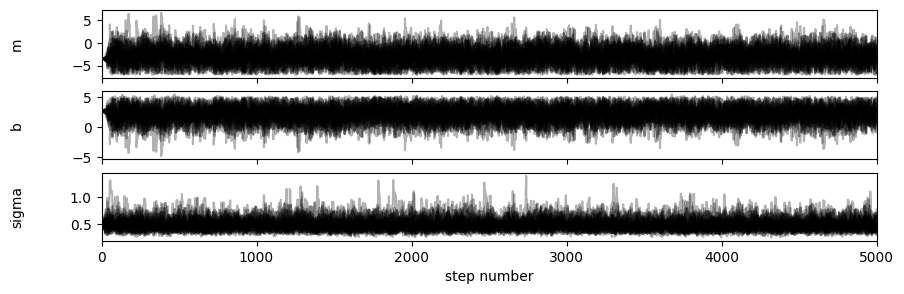

In [528]:
fig, axes = plt.subplots(n_dim, figsize=(10, 3), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'b', 'sigma']

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [529]:
tau = sampler.get_autocorr_time()
print(tau)

[45.57351127 45.49934392 43.89574206]


We can discard a few multiples of the autocorrelation time.

In [530]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


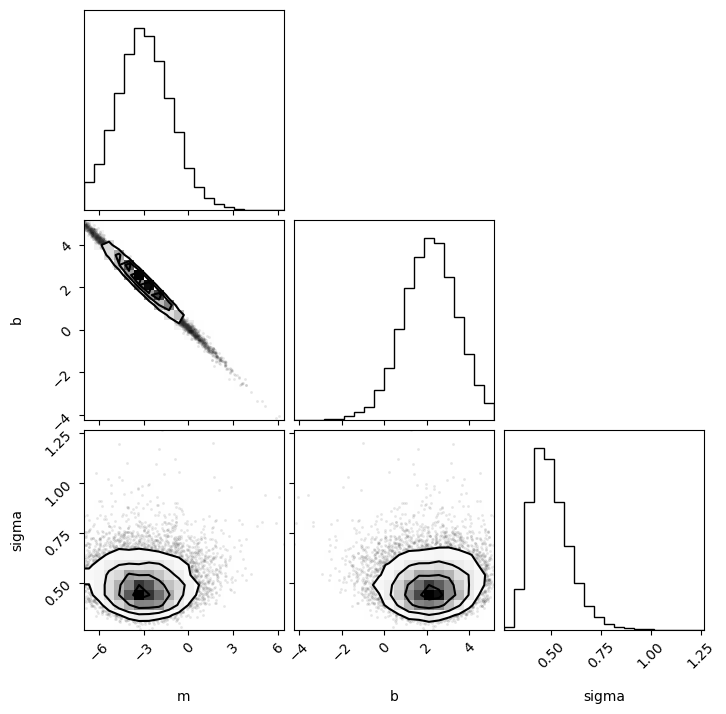

In [532]:
import corner
fig = corner.corner(
    flat_samples, labels=labels
);

Loosely, we can plot the error on a single rotation period as the standard deviation of its posterior distribution.

In [534]:
yerr = np.std(rot_rates_gp_sorted, axis=1)

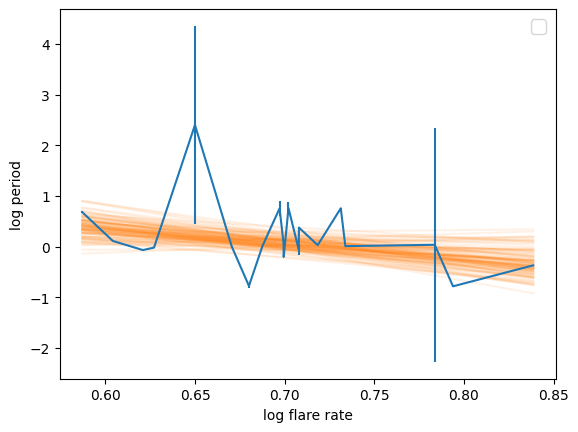

In [548]:
inds = np.random.randint(len(flat_samples), size=100)
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(np.log10(flare_rates_durations_sorted), (np.dot(np.vander(np.log10(flare_rates_durations_sorted), 2), sample[:2])), "C1", alpha=0.1)
plt.errorbar(np.log10(flare_rates_durations_sorted),np.log10(np.mean(rot_rates_gp_sorted, axis=1)),
            yerr=yerr/np.mean(rot_rates_gp_sorted, axis=1) / np.log(10),)
# plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
# plt.
plt.legend(fontsize=14)
# plt.xlim(0, 10)
plt.xlabel("log flare rate")
plt.ylabel("log period");

Looks like we can decently fit a trend line to these rotation rates. How would a flat line perform?

In [513]:
# now need likelihood
@njit
def updated_prior_flat(rotation_inferred, b, flare_rate, sigma_2):
    # this is P_alpha
    # this should probably be log difference, right
    # mu = np.log10(rotation_inferred) - f_rotation(m, b, flare_rate) # the sample - the calculated trend. 
    sigma = sigma_2
    # pdb.set_trace()
    # return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-mu)**2/sigma**2 
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(np.log10(rotation_inferred)-f_rotation_flat(b, flare_rate))**2/sigma**2 

@njit
def likelihood_hierarchical_flat(samples, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained):
    """
    the regular prior was normal in log period
    """
    total_likelihood = 1.
    # looping over whole populatio
    for i, rotations_inferred in enumerate(samples):
        # right now looping over a single planet's retrieved rotation rate
        likelihood = 0.
        flare_rate = flare_rates_durations_cleaned[i]
        period_guess = rot_rates_constrained[i]
        for rotation_inferred in rotations_inferred:
            updated_prior_val = np.exp(updated_prior_flat(rotation_inferred, b, flare_rate, sigma_2))
            previous_prior_val = np.exp(previous_prior(rotation_inferred, period_guess))
            prior_update = updated_prior_val / previous_prior_val
            likelihood += prior_update
            # if np.isnan(likelihood):
            #     pdb.set_trace()
            # if likelihood < 0:
            #     pdb.set_trace()
        total_likelihood *= likelihood / len(rotations_inferred)
    
    return np.log(total_likelihood)

@njit
def posterior_hierarchical_flat(hypertheta, samples, flare_rates_durations_cleaned, rot_rates_constrained):
    b, sigma_2 = hypertheta
    # likelihood * P_a
    
    hyperprior_val = hyperprior_flat(hypertheta)
    
    if not np.isfinite(hyperprior_val):
        return -np.inf
    
    # error maybe in likelihood func
    likelihood_val = likelihood_hierarchical_flat(samples, b, sigma_2, flare_rates_durations_cleaned, rot_rates_constrained)
    
    # if np.isnan(likelihood_val):
    #     pdb.set_trace()
    return likelihood_val + hyperprior_val

@njit
def f_rotation_flat(b, flare): # just a log-linear functional form
    """
    this is the function that returns the LOG rotation rate.
    """
    return b

# we have all of these. now do a hyperprior.
@njit
def hyperprior_flat(hypertheta):
    b, sigma_2 = hypertheta
    if not (-10 < b < 10 and sigma_2 > 0.2):
        return -np.inf

    
    #gaussian prior on sigma_2
    mu = 0
    sigma = 1
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(sigma_2-mu)**2/sigma**2

In [514]:
# todo: reset x and y and yerr

n_dim = 2
n_walkers = 32 # seems fine. justify?
n_steps = 5000 # seems fine. justify?

# period_guess = 0.76

rot_rates_constrained_cleaned = rot_rates_constrained[flare_rates_durations>0.0]
rot_rates_gp_cleaned = rot_rates_gp[flare_rates_durations>0.0]
flare_rates_durations_cleaned = flare_rates_durations[flare_rates_durations>0.0]

flare_rates_durations_sorted = np.sort(np.log10(flare_rates_durations_cleaned))

rot_rates_constrained_sorted = rot_rates_constrained_cleaned[np.argsort(np.log10(flare_rates_durations_cleaned))]

rot_rates_gp_sorted = rot_rates_gp_cleaned[np.argsort(np.log10(flare_rates_durations_cleaned))]


initial_point = np.array([2.7, .5]) # incorporate as an array and not a list so that we can add to it, etc.
gaussian_scatter_level = 1e-3 # seems fine. justify?

# add some scatter to the walkers around the initial position.
pos = initial_point + gaussian_scatter_level * np.random.randn(n_walkers, n_dim)



sampler = emcee.EnsembleSampler(
    n_walkers, n_dim, posterior_hierarchical_flat, args=(rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)
)
sampler.run_mcmc(pos, n_steps, progress=True);

100%|██████████| 5000/5000 [04:40<00:00, 17.82it/s]


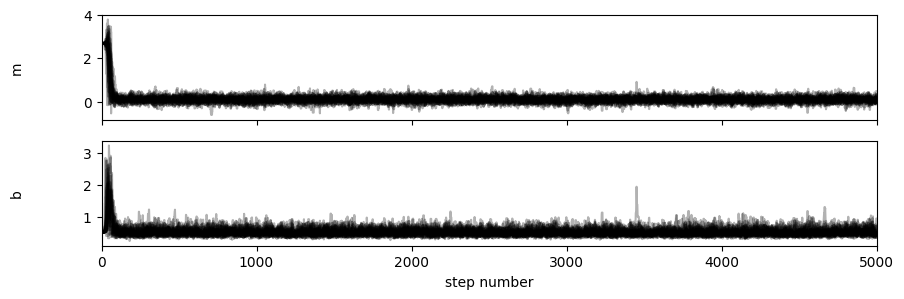

In [515]:
fig, axes = plt.subplots(n_dim, figsize=(10, 3), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'b', 'sigma']

for i in range(n_dim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [516]:
tau = sampler.get_autocorr_time()
print(tau)

[55.30811264 38.75731979]


In [522]:
flat_samples_flat = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 2)


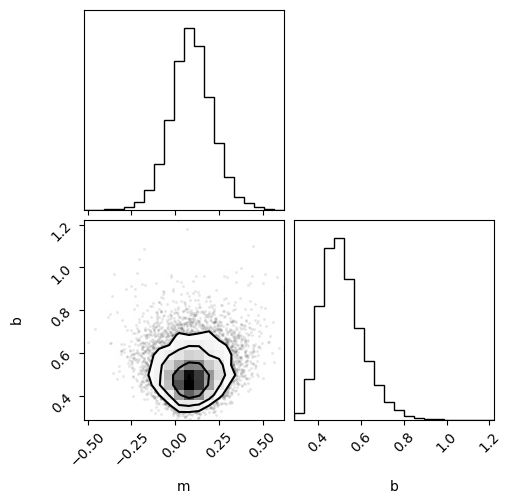

In [523]:
import corner
fig = corner.corner(
    flat_samples_flat, labels=labels
);

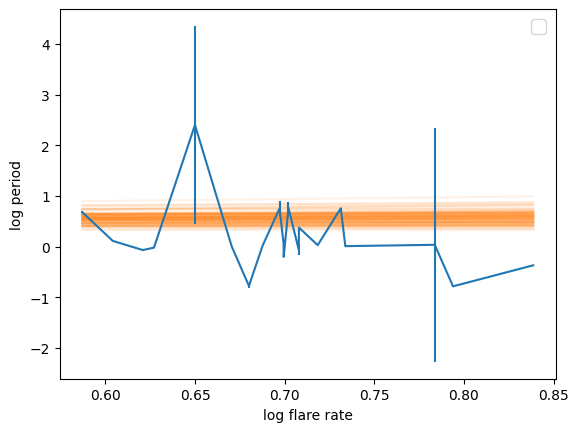

In [547]:
inds = np.random.randint(len(flat_samples_flat), size=100)
for ind in inds:
    sample = flat_samples_flat[ind]
    plt.plot(np.log10(flare_rates_durations_sorted), (np.dot(np.vander(np.log10(flare_rates_durations_sorted), 2), sample[:2])), "C1", alpha=0.1)
plt.errorbar(np.log10(flare_rates_durations_sorted),np.log10(np.mean(rot_rates_gp_sorted, axis=1)),
            yerr=yerr/np.mean(rot_rates_gp_sorted, axis=1) / np.log(10),)
# plt.plot(x0, m_true * x0 + b_true, "k", label="truth")
# plt.
plt.legend(fontsize=14)
# plt.xlim(0, 10)
plt.xlabel("log flare rate")
plt.ylabel("log period");

In [546]:
#need to take the median sample and do BIC

def calc_bic(log_likelihood, n_points, n_params):
    """
    calculates the Bayesian Information Criterion.
    """
    bic = -2 * log_likelihood + np.log(n_points) * n_params
    return bic
n_points = 20
# do BIC.
flat_chain_mean = np.mean(flat_samples, axis=0)
log_likelihood_trend = posterior_hierarchical(flat_chain_mean, rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)

flat_chain_flat_mean = np.mean(flat_samples_flat, axis=0)
log_likelihood_flat = posterior_hierarchical_flat(flat_chain_flat_mean, rot_rates_gp_sorted, flare_rates_durations_sorted,
                                                    rot_rates_constrained_sorted)


bic_trend = calc_bic(log_likelihood_trend, n_points, 3)
bic_flat = calc_bic(log_likelihood_flat, n_points, 2)

delta_bic = bic_trend - bic_flat
delta_bic

0.13167288263905164

We've calcualted a $\Delta$BIC of 0.1. In general, we look for a $\Delta$BIC greater than 2 before we consider the data to prefer one model over the other (cite?).

That's a long way of saying that the trend we found was not statistically significant — even though it aligned with our predictions!

That's not to say that our approach is flawed. It may be that further observations could help us differentiate between a trend and a flat line.